## Преобразуем телеграм-чат в формат для обучение нейросети в Yandex Cloud

Мы задаемся задачей - до-обучить нейросеть на общение в стиле некоторого человека на основе личной телеграм-переписки. Для начала надо экспортировать переписку в формате JSON (файл `result.json`):

In [1]:
import json

with open('result.json',encoding='utf-8') as f:
    js = json.load(f)

messages = js['messages']

print(f"Найдено {len(messages)} сообщений.")


Найдено 31425 сообщений.


Прочитаем все сообщения в словарь, и заменим сразу имена пользователей на user и assistant в соответствии с тем, кого мы хотим моделировать.

In [22]:
user_user_id = "user217687255"
assistant_user_id = "user398283250"

def linearize(x):
    if isinstance(x,list):
        return ' '.join([t if isinstance(t,str) else t['text'] for t in x])
    else:
        return x

msgs = {}
for x in messages:
    if x.get('from_id','xx') not in [user_user_id,assistant_user_id]:
        continue
    if len(x.get('text',''))<1:
        continue
    msg = {
        "from" : "user" if x['from_id'] == user_user_id else "assistant",
        "text" : linearize(x['text']),
        "timestamp" : int(x['date_unixtime']),
        "reply_to" : x.get('reply_to_message_id',None)
    }
    msgs[x['id']] = msg

print(f"Отфильтровано {len(msgs)} сообщений")

Отфильтровано 27169 сообщений


Теперь будем выделять все цепочки сообщений (которые получены ответом не какие-то из предыдущих сообщений). Для простоты мы не будем учитывать отдельные сообщения, по которым сложно выстроить цепочку вопрос-ответ.

In [ ]:
chains = []
processed = set()
for id,m in sorted(msgs.items(),key=lambda x : -x[1]['timestamp']):
    if id in processed:
        continue
    if m['reply_to']:
        xid,x = id,m
        c = [m] # Цепочка сообщений в обратном порядке
        lr = x['from']
        while x['reply_to']:
            processed |= {xid}
            xid = x['reply_to']
            x = msgs.get(xid,None)
            if not x:
                break
            if lr == x['from']:
                c[-1]['text'] = c[-1]['text'] + ' ' + x['text']
            else:
                c.append(x)
                lr = x['from']
        # Последнее сообщение в цепочке должно быть от ассистента
        if c[0]['from'] == 'user':
            c = c[1:]
        if len(c)<2:
            continue
        # Первое сообщение в цепочке должно быть от пользователя
        if c[-1]['from'] == 'assistant':
            c = c[:-1]
        if len(c)>1:
            chains.append(c)

print(f"Found {len(chains)} chains")

Found 2055 chains


Теперь экспортируем все цепочки в формат JSONL, который может быть использован в облаке для до-обучения моделей.

In [41]:
with open('train.jsonl','w',encoding='utf-8') as f:
    for c in chains:
        conv = [ { "role" : "system", "text" : "Ты - Вика Сошникова" }]
        resp = c[0]['text']
        c = c[1:]
        for x in c[::-1]:
            conv.append({ "role" : x['from'], "text" : x['text'] })
        f.write(json.dumps({ 'request' : conv, 'response' : resp },ensure_ascii=False)+'\n')
    

Теперь мы можем загрузить этот файл в облако и инициировать до-обучение модели!

Посмотрим ещё ради интереса на распределение длины цепочек:

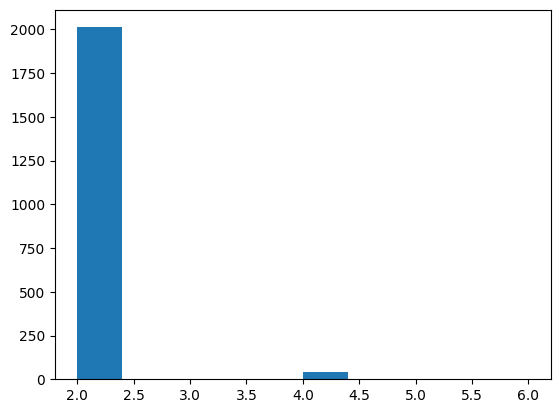

In [42]:
import matplotlib.pyplot as plt 
plt.hist([len(c) for c in chains])
plt.show()

К сожалению, в основном все цепочки сообщений - длины 2, т.к. банальный вопрос-ответ.

Также соберём датасет с фразами только одного пользователя - для до-обучения базовой модели только на ответах.

In [46]:
with open('train.txt','w',encoding='utf-8') as f:
    for id,m in msgs.items():
        if m['from']=='assistant':
            f.write(f"<s>{m['text']}</s>\n")